In [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb) we explored the dataset and obtained insights on what fraction of failures could be prevented by means of predictive replacement. Most of the HDDs which fail do not show substantial change in their SMART metrics and thus won't be detected. Nevertheless, we aim to detect those which do. In this notebook we aim to use machine learning techniques in order to determine whether an HDD is close to failure (and should therefore be turned off), or not.

By means of these techniques we aim to determine a good predictive replacement policy to run together with the preventive replacement policy already in operation. Assume that each HDD working on a certain day give a profit of $1$ unit and that the failure of an HDD yields a cost of $C$ units (where $C \gg 1$). Hence, the revenue on day $t$ is given by 

$$
R_t = A_t - C F_t,
$$

where $A_t$ is the number of HDDs active on day $t$ and $F_t$ is the number of HDDs which failed that same day. We aim to maximize the total revenue in a period of interest $T$, i.e., 

$$
R = \sum_{t \in T} R_t. 
$$

Note that when an HDD is labeled as close to failure by our classification algorithm it will be turned off for good, thus preventing it to produce revenue on the following days. Hence, a trade-off has to be found between turning off HDDs too early or missing to turning them off and incur the failure cost. 

First of all we load the dataframes we saved at the end of [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb) we identified which metrics could be useful in predicting failures. 

As an example, for model Hitachi HDS722020ALA330, we observed that metrics 1, 5, 196 are the only informative ones. We will use only these.

In [2]:
# Pick the model you want to analyze and select the useful_metrics according to the results in Notebook 3 
ModelName = 'Hitachi HDS722020ALA330' 
useful_metrics = ['1', '5', '196']

smart_metrics = ['smart_' + x + '_normalized' for x in useful_metrics]
col_names = ['serial_number', 'date', 'failure', 'state', 'D_to_last'] + smart_metrics

folder_name_model = ModelName.replace(' ', '_')
folder_name = 'Data/' + folder_name_model

# Load the main dataframe : df
df = pd.read_csv(folder_name + '/DataFrame.csv', parse_dates=['date'], usecols = col_names)

# Load the serial_number dataframe : df_serialnumber
df_serialnumber = pd.read_csv(folder_name + '/serialnumber.csv', parse_dates = [1,2,3])
df_serialnumber.rename(columns={'Unnamed: 0':'serial_number'}, inplace=True)
df_serialnumber = df_serialnumber.set_index('serial_number')

df.head()

,serial_number,date,failure,smart_1_normalized,smart_5_normalized,smart_196_normalized,state,D_to_last
0,JK1100B8G3B7AT,2015-01-01,0,100.0,100.0,100.0,healthy,-602
1,JK1100B8G3B7AT,2015-01-02,0,100.0,100.0,100.0,healthy,-601
2,JK1100B8G3B7AT,2015-01-03,0,100.0,100.0,100.0,healthy,-600
3,JK1100B8G3B7AT,2015-01-04,0,100.0,100.0,100.0,healthy,-599
4,JK1100B8G3B7AT,2015-01-05,0,100.0,100.0,100.0,healthy,-598


# Training, testing, and validating data 

Before starting any learning procedure, we have to split the data in training and test data. 

We apply the splitting procedure on the dataframe df_serialnumber, **we maintain 3/4 of the HDDs for training and save the rest for testing**. 

We will then further split the training HDDs in 3 folds so as to perform a **3-fold cross validation** as we train our machine learning procedures and tune the algorithm's parameters.

In [3]:
# Split training and testing HDDs
from sklearn.model_selection import train_test_split

# hdds_X contains a list of unique HDDs (unique serial numbers)
# hdds_y contains a list of 0/1, 1 if the HDD will fail
hdds_X = df_serialnumber.index.values
hdds_y = (df_serialnumber['state'] == 'fail').values

# Split HDDs in training and testing HDDs 
hdds_X_train, hdds_X_test, hdds_y_train, hdds_y_test = train_test_split(hdds_X, hdds_y, random_state = 1, stratify = hdds_y)

print('We use ' + str(len(hdds_X_train)) + ' models for training (' + str(np.sum(hdds_y_train)) + ' failing) and ' + str(len(hdds_X_test)) + ' models for testing (' + str(np.sum(hdds_y_test)) + ' failing).\n')
print('The fraction of failing models in the training set is ' + str(np.mean(hdds_y_train)) + '. In the testing set is ' + str(np.mean(hdds_y_test)) + '.\n')

# Create a mask for the observations of df based on the train/test HDDs split : training_data_mask & test_data_mask
training_models = set(hdds_X_train)       # Set of training HDDs
training_data_mask = [x in training_models for x in df['serial_number']]
test_data_mask = [not x for x in training_data_mask]

print('Thus, we have ' + str(np.sum(training_data_mask)) + ' observations for training and ' + str(np.sum(test_data_mask)) + ' for testing.\n')

We use 3512 models for training (113 failing) and 1171 models for testing (38 failing).

The fraction of failing models in the training set is 0.0321753986333. In the testing set is 0.0324508966695.

Thus, we have 1954262 observations for training and 653358 for testing.



In [4]:
## Split the training HDDs in order to perform an NFolds(=3) cross-validation
from sklearn.cross_validation import KFold

NFolds = 3
kf = KFold(len(hdds_X_train), n_folds = NFolds)    
hdds_X_train_list = hdds_X_train.tolist()          # Create list of training HDDs 

# Select only the training observations and the associated serial numbers
df_train_sn = df.loc[training_data_mask, 'serial_number']

# Create a mask for the training observations based on the NFold cross validation split : training_fold_data_mask & validate_fold_data_mask
## training_fold_data_mask[i,j] = 1 if the i-th observation is in the training set for the j-th cv step
## validate_fold_data_mask[i,j] = 1 if the i-th observation is in the validation set for the j-th cv step
training_fold_data_mask = np.zeros((np.sum(training_data_mask), NFolds))
validate_fold_data_mask = np.zeros((np.sum(training_data_mask), NFolds))

for ind, x in enumerate(df_train_sn) :
    ind_x = hdds_X_train_list.index(x)
    for ind_f, train_test_index in enumerate(kf):
        test_index = train_test_index[1]
        if (ind_x >= test_index[0]) & (ind_x <= test_index[-1]) :
            validate_fold_data_mask[ind, ind_f] = 1
        else : 
            training_fold_data_mask[ind, ind_f] = 1      
        
print('We split the training serial_numbers in {} folds and generate masks for each cross-validation step.\n'.format(NFolds))

num_training_fold = np.sum(training_fold_data_mask, axis = 0)        
num_validate_fold = np.sum(validate_fold_data_mask, axis = 0)

for ind_f, train_test_index in enumerate(kf):
    print('In the cross-validation step {} we have {} training observations and {} vaidating observations'.format(ind_f, num_training_fold[ind_f].astype(int), num_validate_fold[ind_f].astype(int)))        

/home/fabio/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We split the training serial_numbers in 3 folds and generate masks for each cross-validation step.

In the cross-validation step 0 we have 1302999 training observations and 651263 vaidating observations
In the cross-validation step 1 we have 1302473 training observations and 651789 vaidating observations
In the cross-validation step 2 we have 1303052 training observations and 651210 vaidating observations


# Evaluation metric

The policies deduced will be compared with respect to the total revenue $R$, and we will use as a benchmark the preventive replacement policy which is currently in use. 

The following functions are used to compute $R$. 

*revenue_per_day* : It computes $R_t$ for a specific day. It takes in input (1) C, The cost per failure, (2) turned_off, the set of HDDs that the policy in use prescribed to turn off already, (3) hdds, the list of HDDs observed that day (those active in the original dataset), (4) failures, The list of 0/1 capturing whether the observed HDD failed that day.

*compute_revenue_preventive* : It compute $R$ in case we use only **preventive replacement policy** with C cost per failure. The dataframe df needs to have the columns 'failure', 'date', and 'serial_number'.

*compute_revenue_predictive* : It compute $R$ in case we use also **predictive replacement policy** with C cost per failure. The dataframe df needs to have the columns 'failure', 'date', 'serial_number', and 'predictions'. It also prints the actions taken and the change in revenue they cause.

In [5]:
def revenue_per_day(C, turned_off, hdds, failures) :
    '''For a given day, add 1 for every hdd in hdds which do not fail on that day and was not already turned off. Remove 50 if the hdd is on and failed on that day.'''
    # Initialize revenue at 0
    revenue = 0   
    for ind in range(len(hdds)) : 
        off = hdds[ind] in turned_off
        on = 1 - off
        # For each active HDDs either increase the revenue by 1 (if not failing) or decrease it by C (if failing). 
        revenue = revenue + on - on*C*failures[ind]
    return revenue    
   
# List of dates we consider, everyday in 2015, 2016, and 2017    
dates = df.date.unique()    
    
def compute_revenue_preventive(dates, C, df) :
    '''Compute total revenue in the time period determined by dates, given the cost per-failure C and the dataframe df.'''
    # Revenue will be a list of values, where revenue[s] is equal to the revenue on the s-th day
    revenue = []
    # With preventive policy only, we will never turn off any HDD prior to their failure, i.e., turned_off will always be an empty set 
    turned_off = set()
    for ind, day in enumerate(dates) :
        df_day = df[df['date']==day]
        revenue.append(revenue_per_day(C, turned_off, df_day['serial_number'].values, df_day['failure'].values))
    return np.cumsum(revenue)
    
    
def compute_revenue_predictive(dates, C, df) :
    '''Compute total revenue in the time period determined by dates, given the cost per-failure C and the dataframe df.
    The dataframe df must contain a column with the predictions, i.e., the HDDs to turn off'''
    revenue = []
    turned_off = set()

    for ind, day in enumerate(dates) :
        df_day = df[df['date']==day]
        revenue.append(revenue_per_day(C, turned_off, df_day['serial_number'].values, df_day['failure'].values))
        # to_turn_off is a list of HDDs that the predictive replacement policy prescribe to turn off on that day
        to_turn_off = df_day.loc[df_day['predictions'] == 1, 'serial_number'].values
        if len(to_turn_off) > 0 :
            for sn in to_turn_off :
                if sn not in turned_off :
                    # If an HDD in to_turn_off has not been turned off yet, we turn it off and print the outcome of the action taken
                    state_sn = df_serialnumber.loc[sn,'state']
                    last_sn = df_serialnumber.loc[sn,'date_last']
                    diff_days = (last_sn-day).days
                    day_dt = day.astype('M8[D]').astype('O')
                    revenue_diff = (state_sn == 'healthy')*(-diff_days) + (state_sn == 'fail')*(diff_days >0)*(-diff_days + C)
                    print('HDD {} is {} and present till {}-{}-{}. We turn it off on {}-{}-{}: change in revenue of {}'.format(sn, state_sn, last_sn.day, last_sn.month, last_sn.year, day_dt.day, day_dt.month, day_dt.year, revenue_diff) )
            turned_off.update(to_turn_off)     
            
    return np.cumsum(revenue)                       

Note that in case of only preventive replacement, the total revenue is influenced only by the value of $C$. Observe that the total revenue is given by

$$R = \text{max_revenue} - C F$$

where max_revenue is the revenue obtained in a scenario with $C = 0$ and $F$ are the number of failures in the period considered.

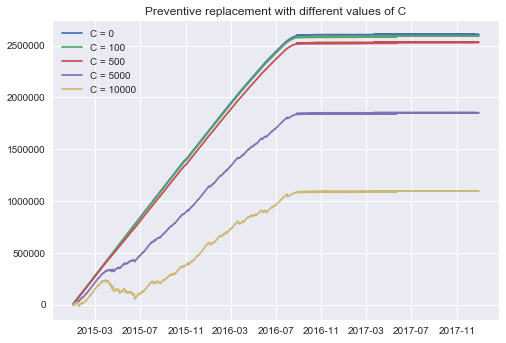

In [6]:
# Compute the total revenue for the case with only preventive replacement and different costs C in Cs

Cs = [0, 100, 500, 5000, 10000]
total_revenue_C = []

for C in Cs :
    cum_revenue = compute_revenue_preventive(dates, C, df)
    total_revenue_C.append(cum_revenue[-1])
    plt.plot(dates, cum_revenue, label = 'C = {}'.format(C))
    
plt.title('Preventive replacement with different values of C')
plt.legend()
plt.show()        

max_revenue = total_revenue_C[0]

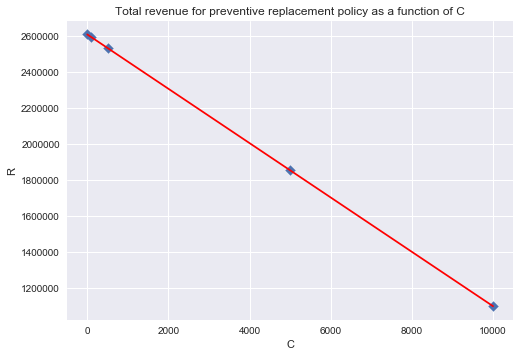

In [7]:
# Compute the total revenue by means of the function above using max_revenue and the total number of failures

Failures = np.sum(hdds_y)

C_vec = np.array([0,max(Cs)])
preventive_revenue = max_revenue - C_vec*Failures

# Note the linear dependence on C
plt.scatter(x = Cs, y = total_revenue_C, marker = 'D')      
plt.plot(C_vec, preventive_revenue, 'r')
plt.title('Total revenue for preventive replacement policy as a function of C')
plt.xlabel('C')
plt.ylabel('R')
plt.show()


# Learning approaches

In the following analysis we will use different approaches to learn whether an HDD is close to failure or not. 

1) **Classifier - Daily**: We look at the daily observations separately and use a random forest classifier. Thus, we lose the temporal dependence of the entries but we maintain a large pool of observations.

2) **Classifier - Time Series**: We look at batches of observations grouped by the various HDDs, i.e., we look at the time series of the SMART metric evolutions. Thus, we keep track of the temporal evolution of the SMART metrics but we have a small pool of observations (as long as we do not overlap the time series).

3) **Survival Regression**: We infer the survival function given a specific observation, i.e., what is the probability that the observed HDD won't fail in the next days? 

4) **Ensemble method**: We combine the above approaches. In particular, an HDD is classified as close to failure if at least one of the above approach classify it as such.


In [8]:
# In the following we will derive four different policies

approaches = ['Classifier_daily', 'Classifier_ts', 'Survival_regressor', 'Ensemble']
Cs = [15, 100, 250, 500, 750, 1000, 1750, 2500, 5000, 7500, 10000]

import itertools

# Create a dictionary with keys the combination of approach and cost, and with item given by the predictions on the testing set
pred_keys = list(itertools.product(approaches, Cs))
pred_dict = {}

## A. Classifier - Daily

As mentioned above, by treating the daily measurments as separate observations, we lose the temporal evolution of the SMART metrics. In order to capture, at least partially, such temporal evolution, we now compute their relative across different span of times. In particular, for every SMART metric $n$ in the dataframe we include the columns 'smart_n_normalized_diffk' for k in temporal_differences (=[1, 7, 14]).

The entries in 'smart_n_normalized_diffk' captures the difference in the SMART metric n on that day with respect to k days before. When the data of k days before is not available, we set the value to 0.


In [9]:
temporal_differences = [1, 7, 14]

for difference in temporal_differences :
    
    # group the df by serial_number and compute the difference as above
    df2 = df.groupby('serial_number').diff(periods = difference)
    suff = '_diff' + str(difference)
    
    # Include the computed differences in the original dataframe
    for smart_metric in smart_metrics :
        new_col = smart_metric + suff
        df[new_col] = df2[smart_metric]
        
del df2        
# Replace the NaN with zeros (metric not available k days before)        
df = df.fillna(0)

Before using supervised machine learning techniques to determine whether a HDD is approaching failure, we need to determine X (the matrix of observations and features) and y (the vector of labels). 

As for the matrix **X**, we aim to use only the SMART metrics measurements (and relative differences) to make our predictions. 

As for the labels **y**, we aim to label with $1$ (close to failure) every observation of an HDD we would be glad to turn off. By this, we mean that we do not want to turn off a HDD which is not close to failure because we would miss on the revenue it would produce in between that day and its last appearance.

We thus need to set a time window $W$ and we will label with a $1$ every observation of an HDD which will fail in the following $W$ days. The choice of $W$ should depend on $C$, i.e., $W = W(C)$. In particular, we do not want $W > C$ because that would mean turning off HDDs who would produce more revenue than the failure cost. 

However, from the exploratory data analysis performed, we observed that there are no evidence of future failure more than 14 days before it, we thus select $W(C)$ as follows

$$
W(C) = \min(C-1, 15).
$$

As an example, note that for $C = 0, 1$ there is no advantage in turning off an HDD, and that is reflected by our labeling procedure, indeed no positive labels are assigned and the predictive replacement policy will not prescribe any additional action. On the other hand, as $C$ grows large, the window is set to remain at $15$. 

We now set $W(C)$ and use the masks created above to obtain the feature matrix X and the labels y, both for the training and the test HDDs. We will be mostly interested in large values of $C$, thus in the following analysis we will set $W = 15$.


In [10]:
# Define the window for a case with large C. Note that the threshold might be model dependent, for model Hitachi HDS722020ALA330 we set it at 15.
C = 5000
W = min(15, C-1)

# Include a label column in the dataset. The entry is 1 if the HDD observed is going to fail in less than W days. 
df['label'] = (df['state'] == 'fail') & (df['D_to_last'] > -W).astype(int)

# Select the column of the dataframe containing the features we will base our predictions on.
col_X = [col for col in df.columns if col.startswith('smart')]

# Use the masks defined above to determine X and y both for training and testing. 
X_train = df[col_X].loc[training_data_mask, :].values
X_test = df[col_X].loc[test_data_mask, :].values
y_train = df.loc[training_data_mask, 'label'].values
y_test = df.loc[test_data_mask, 'label'].values

### PCA Analysis - What is the intrinsic dimension of the dataset?

The datasets are ready to be used by the classifier. Before doing that, we spend some time trying to understand the dimensionality of the problem and whether the principal components are useful in determining whether an HDD is healthy or close to failure.

After normalizing the columns, the **intrinsic dimension seems to be 4** as observed in the histogram with the explined variance ratios. However, as we observe in the scatter plots below, the pca components do not seem to separate the HDDs close to failure from the others. In fact, as we observed in the EDA section, most of the HDDs that fail do not show any change in their SMART metrics and are therefore hidden among the healthy HDDs.

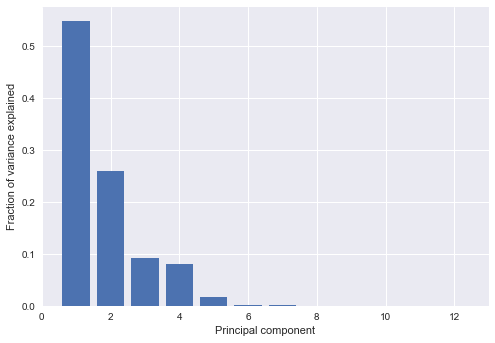

In [11]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.cm as cm

scaler = Normalizer()
pca = PCA()
steps = [('scaler', scaler), ('pca', pca)]
pipeline = Pipeline(steps)

pipeline.fit(X_train)

# We now plot the ratio of explained variance captured by the different principal components.
plt.bar(range(1,len(col_X)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Fraction of variance explained')
plt.show()

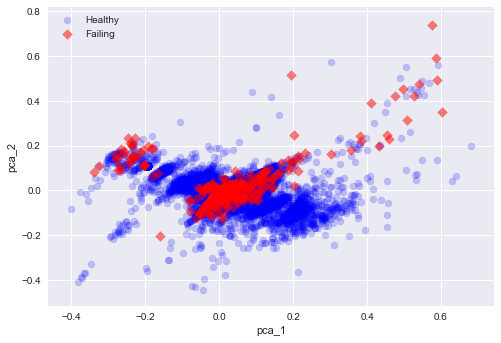

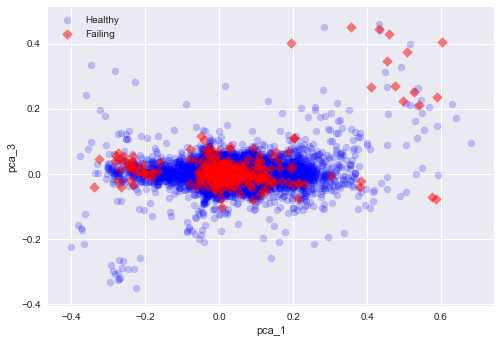

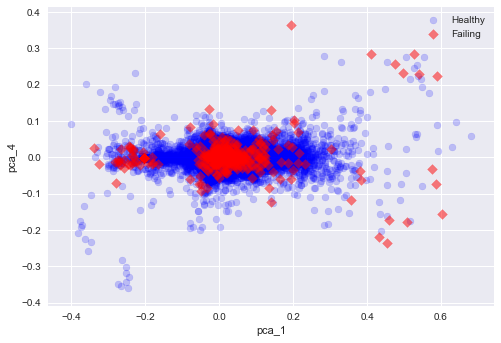

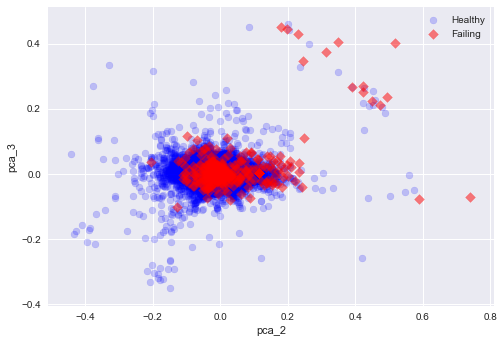

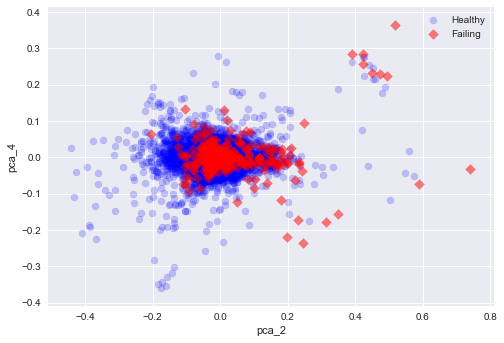

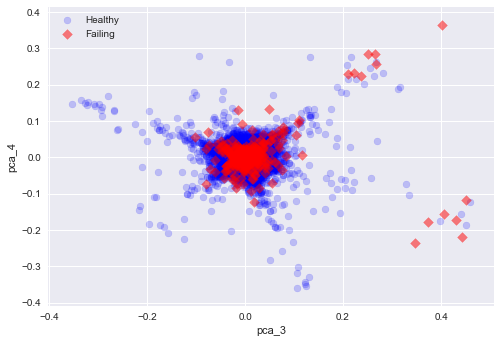

In [12]:
# Let us now observe whether the principal components can distinguish HDDs close to failure from those which are not.
n_comp = 4

pca2 = PCA(n_components = n_comp)
steps = [('scaler', scaler), ('pca', pca2)]
pipeline = Pipeline(steps)

pipeline.fit(X_train)

X_train_pca2 = pipeline.transform(X_train)

# Create a data frame containing the labels of the training observations and ...
df_pca = pd.DataFrame({'cluster' : y_train})

# ... the value of the first n_comp PCA components
for i in range(1, n_comp + 1):
    col_name = 'pca_' + str(i)
    df_pca[col_name] = X_train_pca2[:, i-1]

# Plot the scatterplots obtained by considering any 2 principal components among the first n_comp. Look at the patterns for halthy HDDs and close to failure HDDs.    
for ind_x in np.arange(1,n_comp) :
    for ind_y in np.arange (ind_x + 1, n_comp + 1) :
        plt.scatter(x = df_pca.loc[df_pca['cluster'] == 0, df_pca.columns[ind_x]], y = df_pca.loc[df_pca['cluster'] == 0, df_pca.columns[ind_y]], c = 'b', alpha = 0.2, label = 'Healthy')
        plt.scatter(x = df_pca.loc[df_pca['cluster'] == 1, df_pca.columns[ind_x]], y = df_pca.loc[df_pca['cluster'] == 1, df_pca.columns[ind_y]], marker = 'D', c = 'r', alpha = 0.5, label = 'Failing')
        plt.xlabel(df_pca.columns[ind_x])
        plt.ylabel(df_pca.columns[ind_y])
        plt.legend()
        plt.show()
        
del df_pca

We are now ready to train a classifier which would prescribe a predictive replacement policy and observe the performance it would have on the testing dataset. 

Observe that the training dataset is quite large, in particular for the model Hitachi HDS722020ALA330 we have almost 2 millions observations and 12 features. This makes classifiers such as KNeighbors and SVM quite inefficient due to the long training procedure. 

For this reason, we consider a **Random Forest classifier**.

Before testing the classifier we need to tune the parameters of the random forest. To do so, we rely on cross validations using the masks defined above. The parameters to tune are: 

- The number of features to randomly consider in every tree *max_features*. We consider trees with 2, 'sqrt' (3 or 4), and 0.5 (6) features. 
- The number of trees *n_estimators*. We consider 10, 100, and 1000 trees. 
- The threshold probability for positive class prediction *threshold_probs*. By default, the random forest classifier uses 0.5, we consider 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, and 0.95. 


**The code below requires some time to run. If interested only in the classifier with the best parameters skip the cells which state that in the comment.**  

To save time, we stored the results obtained in the dictionary *best_params_by_C* where the key is the cost $C$ and the value is ((max_features, n_estimators), threshold_probs). 

**Best parameters**. We need to determine a metric that could be used to synthetize the performance of a classifier on the validating data and used as a proxy for the generalization performance of the algorithm. We use the following metric

$$ (C-1) * tp - \mathbb{E}\big[df[\text{D_to_last}]\big] * fp, $$

i.e., the expected gain minus the expected loss we have by using the selected policy. Note that the number of tp (true positive) and fp (false positive) is not relative to the single HDDs identified, multiple tp and fp can be associated to the same HDD.



In [13]:
Cs = [15, 100, 250, 500, 750, 1000, 1750, 2500, 5000, 7500, 10000]

best_params_by_C = { 15: ((2, 10), 0.9),
                    100: ((2, 10), 0.9),
                    250: ((2, 10), 0.9),
                    500: ((2, 10), 0.9),
                    750: ((2, 10), 0.9),
                   1000: ((2, 10), 0.9),
                   1750: ((2, 10), 0.9),
                   2500: ((2, 10), 0.9),
                   5000: ((2, 10), 0.55),
                   7500: ((2, 10), 0.55),
                  10000: ((2, 10), 0.55)}

# Function used to return the key associated to the highest value in a dictionary.
def sort_keys_by_val(d) :
    '''a) create a list of the dict's keys and values; b) return the key with the max value''' 
    v = list(d.values())
    k = list(d.keys())
    return sorted(zip(k, v), key=lambda x: -x[1])

In [19]:
######### TO BE SKIPPED IF INTERESTED ONLY IN THE BEST PARAMETERS #########

# Tune the parameters of the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools

# List of parameters we aim to choose from. 
max_features_param = [2, 'sqrt', 0.5]
n_estimators_param = [10, 100, 1000]
threshold_probs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] 

# Create scores, a dictionary in which the keys are a combination of parameters and the items are equal to [tn, fp, fn, tp] (one such list per cross-validating step).
params = list(itertools.product(max_features_param, n_estimators_param))
keys = list(itertools.product(params, threshold_probs))
scores = {k: [] for k in keys}
# scores_training is the version of scores used to evaluate the performance on the training data (not the validating)
scores_training = {k: [] for k in keys}

# Iterate over the parameters needed in the initialization of the Random Forest classifier
for ind, param in enumerate(params) :
    
    rf = RandomForestClassifier(random_state=10, max_features = param[0], n_estimators = param[1])
    
    # Cross validate the results over the various folds
    for fold in range(NFolds) :
        # Split the training data in training and validating data (use masks created above)
        X_train_fold = X_train[ training_fold_data_mask[:, fold].astype(bool), :]
        y_train_fold = y_train[ training_fold_data_mask[:, fold].astype(bool)]
        X_val_fold = X_train[ validate_fold_data_mask[:, fold].astype(bool), :]
        y_val_fold = y_train[ validate_fold_data_mask[:, fold].astype(bool)]

        # Fit the training data and predict the probabilities for both training and validating data
        rf.fit(X_train_fold, y_train_fold)
        y_val_fold_proba = rf.predict_proba(X_val_fold)
        y_train_fold_proba = rf.predict_proba(X_train_fold)
        
        # Iterate over th threshold probabilities and save the list [tn, fp, fn, tp]
        for prob in threshold_probs :
            y_val_fold_pred = (y_val_fold_proba[:,1] > prob)
            tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_fold_pred).ravel()
            scores[(param,prob)].append([tn, fp, fn, tp])
            
            y_train_fold_pred = (y_train_fold_proba[:,1] > prob)
            tn, fp, fn, tp = confusion_matrix(y_train_fold, y_train_fold_pred).ravel()
            scores_training[(param,prob)].append([tn, fp, fn, tp])
            

In [20]:
######### TO BE SKIPPED IF INTERESTED ONLY IN THE BEST PARAMETERS #########

# Compute the best parameters for the random forest classifier. Based on the metric (gain_stop_failure*tp - loss_stop_healthy*fp)
# The results are already stored in the dictionary best_params_by_C initialized above. The code here provide a further comparison between the performance on the training and validating dataset.

best_params_by_C = {}
loss_stop_healthy = - df.loc[training_data_mask, 'D_to_last'].mean()    # Average cost to pay for a fp (prediction of an healthy HDD as failing)
    
for C in Cs :
    
    gain_stop_failure = C - 1
    
    eval_metric_val = {}
    eval_metric_train = {}
    confusion_metric_val = {}
    confusion_metric_train = {}

    # Compute metrics for the validating datasets
    for k, v in scores.items() :
        # Average performance across the cross validation steps
        tn, fp, fn, tp = (sum(i)/ len(v) for i in zip(*v))
        confusion_metric_val[k] = [tn, fp, fn, tp]
        eval_metric_val[k] = gain_stop_failure*tp - loss_stop_healthy*fp
    
    # Compute metrics for the training datasets
    for k, v in scores_training.items() :
        tn, fp, fn, tp = (sum(i)/ len(v) for i in zip(*v))
        confusion_metric_train[k] = [tn, fp, fn, tp]
        eval_metric_train[k] = gain_stop_failure*tp - loss_stop_healthy*fp
    
    # Sort keys of eval_metric_val and eval_metric_train by their metric score
    sorted_params_val = sort_keys_by_val(eval_metric_val)
    sorted_params_train = sort_keys_by_val(eval_metric_train)
    
    # Print best sets of parameters for every C
    print('\nC = {}\n'.format(C))
    print('Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :\n ')
    for i in range(2) :
        print(sorted_params_val[i], confusion_metric_val[sorted_params_val[i][0]])
    
    print('\nTop 2 settings (training data) - parameters, metric, [tn, fp, fn, tp] :\n ')
    for i in range(2) :
        print(sorted_params_train[i], confusion_metric_train[sorted_params_train[i][0]])
    
    # Store the best parameters in the dictionary best_params_by_C
    best_params_by_C[C] = sorted_params_val[0][0]       


C = 0

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
(((2, 10), 0.9), -0.0) [650875.66666666663, 0.0, 545.0, 0.0]
(((2, 10), 0.95), -0.0) [650875.66666666663, 0.0, 545.0, 0.0]

Top 2 settings (training data) - parameters, metric, [tn, fp, fn, tp] :
 
(((2, 100), 0.95), -6.0) [1301751.3333333333, 0.0, 1084.0, 6.0]
(((2, 1000), 0.95), -8.3333333333333339) [1301751.3333333333, 0.0, 1081.6666666666667, 8.3333333333333339]

C = 100

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
(((2, 10), 0.9), 0.0) [650875.66666666663, 0.0, 545.0, 0.0]
(((2, 10), 0.95), 0.0) [650875.66666666663, 0.0, 545.0, 0.0]

Top 2 settings (training data) - parameters, metric, [tn, fp, fn, tp] :
 
(((2, 1000), 0.55), 15706.438957519513) [1301750.3333333333, 1.0, 928.33333333333337, 161.66666666666666]
((('sqrt', 1000), 0.55), 15706.438957519513) [1301750.3333333333, 1.0, 928.33333333333337, 161.66666666666666]

C = 250

Top 2 settings (validating data) - par

In [14]:
# Evaluate the performance (total revenue) of the predictive replacement policy with respect to the preventive replacement policy alone.

# Consider the dataframe with only the testing data
df_test = df.loc[test_data_mask, :]

# The preventive replacement revenue is given by (preventive_revenue_C0 - C*Failures_test). Compute the parameters not depending on C.
preventive_revenue_C0 = compute_revenue_preventive(dates, 0, df_test)[-1]
Failures_test = np.sum(hdds_y_test)

revenue_pred = []
revenue_prev = []

# Train the Random Forest classifier on all the training dataset (including the validation sets) and then predict the values for the testing set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Iterate over C
for C in Cs :
    # Extract the best parameters obtained from the cross validation above.
    best_params = best_params_by_C[C][0]
    prob_thresh = best_params_by_C[C][1]

    # Fit the Random Forest Classifier
    rf = RandomForestClassifier(random_state=10, max_features = best_params[0], n_estimators = best_params[1])
    rf.fit(X_train, y_train)
    
    # Predict
    rf_y_train_proba = rf.predict_proba(X_train)
    rf_y_test_proba = rf.predict_proba(X_test)

    # For every C, we plot :
    print('\nC = {}\n'.format(C))

    # A) The performance on the training set.
    y_train_pred = (rf_y_train_proba[:,1] > prob_thresh)
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    print('Training data performance: tn = {} '.format(tn) + ', fp = {} '.format(fp)+ ', fn = {} '.format(fn)+ ', tp = {} '.format(tp))

    # B) The performance on the testing set.
    y_test_pred = (rf_y_test_proba[:,1] > prob_thresh)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    print('Test data performance: tn = {} '.format(tn) + ', fp = {} '.format(fp)+ ', fn = {} '.format(fn)+ ', tp = {} '.format(tp))
    
    # C) The total revenue when we use only preventive replacement. 
    preventive_revenue = preventive_revenue_C0 - C*Failures_test
    print('The total revenue with only preventive replacement is given by {}'.format(preventive_revenue))
    revenue_prev.append(preventive_revenue)
    
    # D) The total revenue when we use also predictive replacement. We also print all the additional actions taken and the change in revenue they cause.
    df_test['predictions'] = y_test_pred
    pred_dict[('Classifier_daily', C)] = y_test_pred
    predictive_revenue = compute_revenue_predictive(dates, C, df_test)[-1]
    print('The total revenue with also predictive replacement (Classifier - Daily) is given by {}'.format(predictive_revenue))
    print('\nDifference in total revenue = {}'.format(predictive_revenue - preventive_revenue))
    revenue_pred.append(predictive_revenue)
    
del df_test


C = 15

Training set performance: tn = 1952627 , fp = 0 , fn = 1610 , tp = 25 
Test data performance: tn = 652827 , fp = 0 , fn = 530 , tp = 1 
The total revenue with only preventive replacement is given by 652788
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 15-1-2015: change in revenue of 0


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total revenue with also predictive replacement is given by 652788

Difference in total revenue = 0

C = 100

Training set performance: tn = 1952627 , fp = 0 , fn = 1610 , tp = 25 
Test data performance: tn = 652827 , fp = 0 , fn = 530 , tp = 1 
The total revenue with only preventive replacement is given by 649558
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 15-1-2015: change in revenue of 0


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total revenue with also predictive replacement is given by 649558

Difference in total revenue = 0

C = 250

Training set performance: tn = 1952627 , fp = 0 , fn = 1610 , tp = 25 
Test data performance: tn = 652827 , fp = 0 , fn = 530 , tp = 1 
The total revenue with only preventive replacement is given by 643858
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 15-1-2015: change in revenue of 0


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total revenue with also predictive replacement is given by 643858

Difference in total revenue = 0

C = 500

Training set performance: tn = 1952627 , fp = 0 , fn = 1610 , tp = 25 
Test data performance: tn = 652827 , fp = 0 , fn = 530 , tp = 1 
The total revenue with only preventive replacement is given by 634358
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 15-1-2015: change in revenue of 0


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total revenue with also predictive replacement is given by 634358

Difference in total revenue = 0

C = 750

Training set performance: tn = 1952627 , fp = 0 , fn = 1610 , tp = 25 
Test data performance: tn = 652827 , fp = 0 , fn = 530 , tp = 1 
The total revenue with only preventive replacement is given by 624858
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 15-1-2015: change in revenue of 0


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total revenue with also predictive replacement is given by 624858

Difference in total revenue = 0

C = 1000

Training set performance: tn = 1952627 , fp = 0 , fn = 1610 , tp = 25 
Test data performance: tn = 652827 , fp = 0 , fn = 530 , tp = 1 
The total revenue with only preventive replacement is given by 615358
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 15-1-2015: change in revenue of 0


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total revenue with also predictive replacement is given by 615358

Difference in total revenue = 0

C = 1750

Training set performance: tn = 1952627 , fp = 0 , fn = 1610 , tp = 25 
Test data performance: tn = 652827 , fp = 0 , fn = 530 , tp = 1 
The total revenue with only preventive replacement is given by 586858
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 15-1-2015: change in revenue of 0


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total revenue with also predictive replacement is given by 586858

Difference in total revenue = 0

C = 2500

Training set performance: tn = 1952627 , fp = 0 , fn = 1610 , tp = 25 
Test data performance: tn = 652827 , fp = 0 , fn = 530 , tp = 1 
The total revenue with only preventive replacement is given by 558358
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 15-1-2015: change in revenue of 0


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total revenue with also predictive replacement is given by 558358

Difference in total revenue = 0

C = 5000

Training set performance: tn = 1952617 , fp = 10 , fn = 1426 , tp = 209 
Test data performance: tn = 652679 , fp = 148 , fn = 501 , tp = 30 
The total revenue with only preventive replacement is given by 463358
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 1-1-2015: change in revenue of 4986
HDD JK11A5B8HZ9STX is fail and present till 29-5-2015. We turn it off on 1-1-2015: change in revenue of 4852
HDD JK1101B9KLLH4T is healthy and present till 19-8-2016. We turn it off on 5-2-2015: change in revenue of -561


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


HDD JK1175YAHSNZKX is healthy and present till 23-12-2015. We turn it off on 20-2-2015: change in revenue of -306
HDD JK11A8B9J49N3F is healthy and present till 5-8-2016. We turn it off on 8-3-2015: change in revenue of -516
HDD JK11A8B9J8E2AF is healthy and present till 21-7-2016. We turn it off on 12-4-2015: change in revenue of -466
HDD JK1101B9GBHE8F is healthy and present till 24-8-2016. We turn it off on 15-4-2015: change in revenue of -497
HDD JK1175YAHU2WRX is healthy and present till 23-12-2015. We turn it off on 22-4-2015: change in revenue of -245
HDD JK1101B9J2YV6F is healthy and present till 21-7-2016. We turn it off on 31-10-2015: change in revenue of -264
HDD JK11A8B9J34AVF is healthy and present till 20-7-2016. We turn it off on 9-12-2015: change in revenue of -224
HDD JK11A8B9J9HXJF is healthy and present till 18-8-2016. We turn it off on 9-1-2016: change in revenue of -222
HDD JK1170YAJDANDT is fail and present till 10-5-2016. We turn it off on 8-2-2016: change in rev

/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


HDD JK1175YAHSNZKX is healthy and present till 23-12-2015. We turn it off on 20-2-2015: change in revenue of -306
HDD JK11A8B9J49N3F is healthy and present till 5-8-2016. We turn it off on 8-3-2015: change in revenue of -516
HDD JK11A8B9J8E2AF is healthy and present till 21-7-2016. We turn it off on 12-4-2015: change in revenue of -466
HDD JK1101B9GBHE8F is healthy and present till 24-8-2016. We turn it off on 15-4-2015: change in revenue of -497
HDD JK1175YAHU2WRX is healthy and present till 23-12-2015. We turn it off on 22-4-2015: change in revenue of -245
HDD JK1101B9J2YV6F is healthy and present till 21-7-2016. We turn it off on 31-10-2015: change in revenue of -264
HDD JK11A8B9J34AVF is healthy and present till 20-7-2016. We turn it off on 9-12-2015: change in revenue of -224
HDD JK11A8B9J9HXJF is healthy and present till 18-8-2016. We turn it off on 9-1-2016: change in revenue of -222
HDD JK1170YAJDANDT is fail and present till 10-5-2016. We turn it off on 8-2-2016: change in rev

/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


HDD JK11A8B9J49N3F is healthy and present till 5-8-2016. We turn it off on 8-3-2015: change in revenue of -516
HDD JK11A8B9J8E2AF is healthy and present till 21-7-2016. We turn it off on 12-4-2015: change in revenue of -466
HDD JK1101B9GBHE8F is healthy and present till 24-8-2016. We turn it off on 15-4-2015: change in revenue of -497
HDD JK1175YAHU2WRX is healthy and present till 23-12-2015. We turn it off on 22-4-2015: change in revenue of -245
HDD JK1101B9J2YV6F is healthy and present till 21-7-2016. We turn it off on 31-10-2015: change in revenue of -264
HDD JK11A8B9J34AVF is healthy and present till 20-7-2016. We turn it off on 9-12-2015: change in revenue of -224
HDD JK11A8B9J9HXJF is healthy and present till 18-8-2016. We turn it off on 9-1-2016: change in revenue of -222
HDD JK1170YAJDANDT is fail and present till 10-5-2016. We turn it off on 8-2-2016: change in revenue of 9908
HDD JK11A8B9J7WMXF is healthy and present till 16-8-2016. We turn it off on 17-5-2016: change in reve

## B. Classifier - Time Series

We now aim to look at the evolution of the smart metrics across multiple days. In approach A we did that by considering relative differences, however if we want a complete description of the SMART metric evolution, we would need to add many features (one per SMART metric and difference in days considered). 

In the following analysis we extend this approach by looking at the SMART metrics across multiple days. 

- **Each observation will look at the SMART metric evolution for an HDD in the last 15 days**. These observations are done every 5 days. We do not sample the time series' every day so as to avoid having extremely correlated observations (1/3 of the time series in two consecutive observations is different) and we also reduce the CPU memory needed to store a time series per day by a factor 5.

- We then need a way to compare time series. The default classifiers available work with floats, not with time series (vectors of int). To obviate this **we define a distance for time series and looked at the distance of each time series with a set of benchmark time series'**. The latter distance values are floats and can be used as inputs for default classifiers. (We also explored the possibility to apply KNeighbor classifiers using this distance directly to the extracted time series', the computational cost however turned out to be prohibitive.) 

The function below splits a time series in a list of sub-time series. Each sub-time series has length at most $15$ and is sampled by the original time series keeping the (at most) $15$ entries prior to an entry with index multiple of $5$. 

In practice, we look at the dataframe every $5$ days and store the observations of the prior $15$ ones.

In [15]:
def daily_to_ts(seq, size = 15, step = 5):
    """ Split up seq in pieces of size """
    #return [seq[i:i+size] for i in range(0, len(seq), int(size/2))]
    return [ seq[max(i - size, 0) : min(i, len(seq))] for i in range(step, len(seq)+1, step)]

In [16]:
# Apply the function daily_to_ts to the columns of interest of the original dataframe.

# The columns of interest are 'serial_number', 'date', 'failure', 'state', 'D_to_last', and the SMART metrics values. Store them in the dataframe df_ts.
df_ts = df[['serial_number', 'date', 'failure', 'state', 'D_to_last'] + smart_metrics]

# Create the dataframe df_grouped, the index are given by the serial_number and the observations are list of sublists obtained by applying daily_to_ts to the full time series associated to every HDD. 
df_grouped = pd.DataFrame()

# The columns we will need in df_grouped are only the SMART metrics, the date of the observations, and the 'D_to_last' (days till last appearance)
for sm in smart_metrics :
    df_grouped[sm] = df_ts.groupby('serial_number')[sm].apply(daily_to_ts)
df_grouped['D_to_last'] = df_ts.groupby('serial_number')['D_to_last'].apply(daily_to_ts)   
df_grouped['date'] = df_ts.groupby('serial_number')['date'].apply(daily_to_ts)   

df_grouped.head()

,smart_1_normalized,smart_5_normalized,smart_196_normalized,D_to_last,date
serial_number,,,,,
JK1100B8G3B7AT,"[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[-602, -601, -600, -599, -598], [-602, -601, ...","[[2015-01-01 00:00:00, 2015-01-02 00:00:00, 20..."
JK1100B9G6R68D,"[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[-523, -522, -521, -520, -519], [-523, -522, ...","[[2015-01-01 00:00:00, 2015-01-02 00:00:00, 20..."
JK1100B9GA4TEE,"[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[-602, -601, -600, -599, -598], [-602, -601, ...","[[2015-01-01 00:00:00, 2015-01-02 00:00:00, 20..."
JK1100B9GA54WE,"[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[-523, -522, -521, -520, -519], [-523, -522, ...","[[2015-01-01 00:00:00, 2015-01-02 00:00:00, 20..."
JK1100B9GA7KVE,"[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, ...","[[-602, -601, -600, -599, -598], [-602, -601, ...","[[2015-01-01 00:00:00, 2015-01-02 00:00:00, 20..."


Each observation now consists of a list of sublists indexed by the serial number of the HDD observed. In the dataframe we aim to obtain **df_ts_ext**, the list of sublists will become a list of unique observations, one per sublist. 

The dataframe will be created from the dictionary ts_data that we initialize starting from the dataframe df_grouped.

We will also label each observation with a 0 or a 1. It will be a 1 if the date of the observation (the last of the 15 days indexing the sublist) is within a window of $15$ days of the failure of the associated HDD.

In [17]:
# Define the threshold window to label oservations as close to failure
W = 15

# Initialize the dictionary we will use to create the dataframe df_ts_ext
ts_data = {}
ts_data['label'] = []                  # List of labels for the observations
ts_data['date'] = []                   # List of dates of the observations
ts_data['serial_number'] = []          # List of the HDDs observed
for sm in smart_metrics :
    ts_data[sm] = []                   # List of time series sublists observed

# Iterate over the HDDs, i.e., indices of df_grouped
for sn in df_grouped.index :
    # We will observe the HDD as many time as the length of the list stored in df_grouped.loc[sn, 'D_to_last']
    ts_data['serial_number'] = ts_data['serial_number'] + [sn]*len(df_grouped.loc[sn, 'D_to_last'])
    
    # Look at the date of the observation
    ts_data['date'] = ts_data['date'] + [np.max(sublist) for sublist in df_grouped.loc[sn, 'date']]
    
    # Determine whether each observation is within the threshold window : is_final
    is_final = [(np.max(sublist) > -W ) for sublist in df_grouped.loc[sn, 'D_to_last']]
    # Determine whether the HDD observed will fail on its last day or is healthy
    is_failing = (df_serialnumber.loc[sn,'state'] == 'fail')
    # Combine the booleans above to determine the labels of each observation
    ts_data['label'] = ts_data['label'] + [(is_failing & is_final[i]) for i in range(len(is_final))]
    
    # Flatten and pile the sublists of the SMART metrics observed at every observation day  
    for sm in smart_metrics :
        ts_data[sm] = ts_data[sm] + [sublist.values for sublist in df_grouped.loc[sn, sm]]
        
# Create the dataframe df_ts_ext from the dictionary ts_data
df_ts_ext = pd.DataFrame(data=ts_data)        
df_ts_ext.head()

del df_grouped

Before starting any learning procedure, we have to split the data in training and test data. We use the same splitting obtained above. Thus identifying training and testing HDDs, and then further determining the same n_fold cross validation split for the training HDDs.

In [18]:
### NFolds, kf, hdds_X_train_list, and training_models  have already been defined in cells [3,4]
## The masks defined below have the exact same meaning as above but are now filtering the observations in df_ts_ext instead of df

# Split the observations in training and testing 

training_data_ts_mask = [(x in training_models) for x in df_ts_ext['serial_number']]
test_data_ts_mask = [(not x) for x in training_data_ts_mask]

print('We use {} time series\' for training and {} for testing.'.format(sum(training_data_ts_mask), sum(test_data_ts_mask)))

# Split the training observations in training and validating

df_ts_train_sn = df_ts_ext.loc[training_data_ts_mask, 'serial_number']

training_fold_data_ts_mask = np.zeros((np.sum(training_data_ts_mask), NFolds))
validate_fold_data_ts_mask = np.zeros((np.sum(training_data_ts_mask), NFolds))

for ind, x in enumerate(df_ts_train_sn) :
    ind_x = hdds_X_train_list.index(x)
    for ind_f, train_test_index in enumerate(kf):
        test_index = train_test_index[1]
        if (ind_x >= test_index[0]) & (ind_x <= test_index[-1]) :
            validate_fold_data_ts_mask[ind, ind_f] = 1
        else : 
            training_fold_data_ts_mask[ind, ind_f] = 1      
        
print('We split the training serial_numbers in {} folds and generate masks for each cross-validation step.\n'.format(NFolds))

num_training_fold = np.sum(training_fold_data_ts_mask, axis = 0)        
num_validate_fold = np.sum(validate_fold_data_ts_mask, axis = 0)

for ind_f, train_test_index in enumerate(kf):
    print('In the cross-validation step {} we have {} training observations and {} vaidating observations'.format(ind_f, num_training_fold[ind_f].astype(int), num_validate_fold[ind_f].astype(int)))


We use 389645 time series' for training and 130271 for testing.
We split the training serial_numbers in 3 folds and generate masks for each cross-validation step.

In the cross-validation step 0 we have 259799 training observations and 129846 vaidating observations
In the cross-validation step 1 we have 259681 training observations and 129964 vaidating observations
In the cross-validation step 2 we have 259810 training observations and 129835 vaidating observations


### A suitable distance metric for time series 

We claim that the standard Euclidean distance is not suitable for comparing time series in our case. There are two reasons for this: 

1) In its basic form, it cannot compare time series of different length (component by component computation). 
2) The Euclidean metric does not capture the closeness of two shifted time series, by this we means that the distance between $(x_1,\ldots,x_{100})$ and $(x_2,\ldots,x_{101})$ could be extremely large. This is not what we want, in fact such time series would show a very similar behavior and we aim to capture such closeness.

In order to overcome this problem, we use the **Dynamic Time Warping** distance which allows to 'speed up/down' and thus 'shift' the time series. A thorough description of this distance is beyond the scope of this notebook, details can be found on [Wikipedia](https://en.wikipedia.org/wiki/Dynamic_time_warping) or in the reference within this [blog post](http://alexminnaar.com/time-series-classification-and-clustering-with-python.html). 

In the functions below, we define the dtw distance to fit our case. In particular, we have that:

- dtw_distance(s1, s2) : compute the dtw distance of two time series (no need for equal length).
- dtw_distance_vec(l1, l2) : compute the dtw distance of two lists of time series by calling dtw_distance(s1, s2) component by component.


In [19]:
def dtw_distance(s1, s2):
    '''Compute dtw distance of time series s1 and s2'''
    DTW={}
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min( DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)]) 
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def dtw_distance_vec(l1, l2):
    '''Compute dtw distance of two lists of time series l1 and l2, the lists are assumed of the same length'''
    dist = 0
    for i in range(len(l1)):
        dist = dist + dtw_distance(l1[i], l2[i])    
    return dist

Note that in the [blog post](http://alexminnaar.com/time-series-classification-and-clustering-with-python.html) is discussed how to exploit dtw distance to favor an application of KNeighbors classifier. Such approach is not feasible with our dataset, whose dimensions are out of range for an efficient implementation of KNeighbors calssifier. To obviate this we rely on an original idea which exploits the dtw distance of the observed time series with some predetermined time series used as benchmarks.

The benchmark time series we consider are proxies for specific behaviors of the time series: 

- [100] - Proxy for a constantly good behavior (100 is the typical value for a SMART metric)
- [1] - Proxy for a constantly bad behavior (1 is the minimal value for a SMART metric)
- [100, 1] - Proxy for a worsening behavior
- [1, 100] - Proxy for an improving behavior
- [100, 1, 100] - Proxy for a worsening and then improving behavior
- [1, 100, 1] - Proxy for an improving and then worsening behavior

We further point out that the computation of the dtw distance require $\mathcal{O}(N_1 N_2)$ time, where $N_1$ and $N_2$ are the lengths of the two time series. The benchmark time series defined above are short and can be assumed to remain constant as the window of observation ($15$ in this specific case) grows large. Thus the complexity grows linearly in the window chosen.  

In [20]:
# Define the list of benchmark time series
benchmark_ts = [[100] , [1], [100, 1], [1, 100], [100, 1, 100], [1, 100, 1]]

# Compute the distances of every time series of every SMART metric and store it in a new column (one for each benchmark time series and each SMART metric)
for ind, ben_ts in enumerate(benchmark_ts) : 
    for sm in smart_metrics :
        col_name = sm + '_dist_to_' + str(ind)
        df_ts_ext[col_name] = [dtw_distance(s, ben_ts) for s in df_ts_ext[sm]]

df_ts_ext.head()

,date,label,serial_number,smart_196_normalized,smart_1_normalized,smart_5_normalized,smart_1_normalized_dist_to_0,smart_5_normalized_dist_to_0,smart_196_normalized_dist_to_0,smart_1_normalized_dist_to_1,...,smart_196_normalized_dist_to_2,smart_1_normalized_dist_to_3,smart_5_normalized_dist_to_3,smart_196_normalized_dist_to_3,smart_1_normalized_dist_to_4,smart_5_normalized_dist_to_4,smart_196_normalized_dist_to_4,smart_1_normalized_dist_to_5,smart_5_normalized_dist_to_5,smart_196_normalized_dist_to_5
0,2015-01-05,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0]","[100.0, 100.0, 100.0, 100.0, 100.0]","[100.0, 100.0, 100.0, 100.0, 100.0]",0.0,0.0,0.0,221.370730,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143
1,2015-01-10,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...",0.0,0.0,0.0,313.065488,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143
2,2015-01-15,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...",0.0,0.0,0.0,383.425351,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143
3,2015-01-20,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...",0.0,0.0,0.0,383.425351,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143
4,2015-01-25,False,JK1100B8G3B7AT,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...",0.0,0.0,0.0,383.425351,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,140.007143,140.007143,140.007143


We can now prepare the training and testing matrices by means of the masks defined above.

In [21]:
num_cols = len(smart_metrics) * len(benchmark_ts)

Xts_train = df_ts_ext.iloc[training_data_ts_mask, -num_cols :].values
Xts_test = df_ts_ext.iloc[test_data_ts_mask, -num_cols :].values
yts_train = df_ts_ext.loc[training_data_ts_mask, 'label'].values
yts_test = df_ts_ext.loc[test_data_ts_mask, 'label'].values


### Machine learning classifier

We are now ready to train a classifier which would prescribe a predictive replacement policy and observe the performance it would have on the testing dataset. For the same reasons as in the approach A, we consider a **Random Forest classifier**.

The same parameters have to be tuned and as above **the code below requires some time to run. If interested only in the classifier with the best parameters skip them.**  

To save time, we stored the results obtained in the dictionary *best_params_by_C* where the key is the cost $C$ and the value is ((max_features, n_estimators), threshold_probs). 


In [22]:
best_params_ts_by_C = {15: ((2, 10), 0.8),
                      100: ((2, 10), 0.8),
                      250: ((2, 10), 0.8),
                      500: ((2, 10), 0.8),
                      750: ((2, 10), 0.8),
                     1000: ((2, 10), 0.8),
                     1750: ((0.5, 10), 0.6),
                     2500: ((0.5, 10), 0.6),
                     5000: ((0.5, 10), 0.6),
                     7500: ((0.5, 10), 0.6),
                    10000: ((0.5, 10), 0.6)}

def sort_keys_by_val(d) :
    '''a) create a list of the dict's keys and values; b) return the key with the max value''' 
    v = list(d.values())
    k = list(d.keys())
    return sorted(zip(k, v), key=lambda x: -x[1])

In [14]:
######### TO BE SKIPPED IF INTERESTED ONLY IN THE BEST PARAMETERS #########

# Tune the parameters of the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools

# List of parameters we aim to choose from. 
max_features_param = [2, 'sqrt', 0.5]
n_estimators_param = [10, 100, 1000]
threshold_probs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] 

# Create scores, a dictionary of lists with keys equal to a combination of parameters and item equal to a list of lists [tn, fp, fn, tp], one list per cross-validating step.
params = list(itertools.product(max_features_param, n_estimators_param))
keys = list(itertools.product(params, threshold_probs))
scores = {k: [] for k in keys}
scores_training = {k: [] for k in keys}

for ind, param in enumerate(params) :
    
    rf = RandomForestClassifier(random_state=10, max_features = param[0], n_estimators = param[1])
    
    for fold in range(NFolds) :
        Xts_train_fold = Xts_train[ training_fold_data_ts_mask[:, fold].astype(bool), :]
        yts_train_fold = yts_train[ training_fold_data_ts_mask[:, fold].astype(bool)]
        Xts_val_fold = Xts_train[ validate_fold_data_ts_mask[:, fold].astype(bool), :]
        yts_val_fold = yts_train[ validate_fold_data_ts_mask[:, fold].astype(bool)]

        rf.fit(Xts_train_fold, yts_train_fold)
        yts_val_fold_proba = rf.predict_proba(Xts_val_fold)
        yts_train_fold_proba = rf.predict_proba(Xts_train_fold)
        
        for prob in threshold_probs :
            yts_val_fold_pred = (yts_val_fold_proba[:,1] > prob)
            tn, fp, fn, tp = confusion_matrix(yts_val_fold, yts_val_fold_pred).ravel()
            scores[(param,prob)].append([tn, fp, fn, tp])
            
            yts_train_fold_pred = (yts_train_fold_proba[:,1] > prob)
            tn, fp, fn, tp = confusion_matrix(yts_train_fold, yts_train_fold_pred).ravel()
            scores_training[(param,prob)].append([tn, fp, fn, tp])
            
    
    print(param)

(2, 10)
(2, 100)
(2, 1000)
('sqrt', 10)
('sqrt', 100)
('sqrt', 1000)
(0.5, 10)
(0.5, 100)
(0.5, 1000)


In [15]:
######### TO BE SKIPPED IF INTERESTED ONLY IN THE BEST PARAMETERS #########

# Compute the best parameters for the random forest classifier. Based on the metric (gain_stop_failure*tp - loss_stop_healthy*fp)
# The results are already stored in the dictionary best_params_by_C initialized above. The code here provide a further comparison between the performance on the training and validating dataset.

Cs = [15, 100, 250, 500, 750, 1000, 1750, 2500, 5000, 7500, 10000]

best_params_ts_by_C = {}

for C in Cs :
    
    gain_stop_failure = C - 1
    loss_stop_healthy = - df.loc[training_data_mask, 'D_to_last'].mean()
    eval_metric_val = {}
    eval_metric_train = {}
    confusion_metric_val = {}
    confusion_metric_train = {}

    
    for k, v in scores.items() :
        tn, fp, fn, tp = (sum(i)/ len(v) for i in zip(*v))
        confusion_metric_val[k] = [tn, fp, fn, tp]
        eval_metric_val[k] = gain_stop_failure*(tp) - loss_stop_healthy*(fp)
    
    for k, v in scores_training.items() :
        tn, fp, fn, tp = (sum(i)/ len(v) for i in zip(*v))
        confusion_metric_train[k] = [tn, fp, fn, tp]
        eval_metric_train[k] = gain_stop_failure*(tp) - loss_stop_healthy*(fp)
    

    sorted_params_val = sort_keys_by_val(eval_metric_val)
    sorted_params_train = sort_keys_by_val(eval_metric_train)
    print('\nC = {}\n'.format(C))
    print('Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :\n ')
    for i in range(2) :
        print(sorted_params_val[i], confusion_metric_val[sorted_params_val[i][0]])
    
    print('\nTop 2 settings (training data) - parameters, metric, [tn, fp, fn, tp] :\n ')
    for i in range(2) :
        print(sorted_params_train[i], confusion_metric_train[sorted_params_train[i][0]])
        
    best_params_ts_by_C[C] = sorted_params_val[0][0]       


C = 0

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
(((2, 10), 0.8), -0.0) [129773.33333333333, 0.0, 108.33333333333333, 0.0]
(((2, 10), 0.85), -0.0) [129773.33333333333, 0.0, 108.33333333333333, 0.0]

Top 2 settings (training data) - parameters, metric, [tn, fp, fn, tp] :
 
(((2, 1000), 0.95), -0.0) [259546.66666666666, 0.0, 216.66666666666666, 0.0]
((('sqrt', 1000), 0.95), -0.0) [259546.66666666666, 0.0, 216.66666666666666, 0.0]

C = 100

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
(((2, 10), 0.8), 0.0) [129773.33333333333, 0.0, 108.33333333333333, 0.0]
(((2, 10), 0.85), 0.0) [129773.33333333333, 0.0, 108.33333333333333, 0.0]

Top 2 settings (training data) - parameters, metric, [tn, fp, fn, tp] :
 
(((2, 100), 0.5), 6665.9999999999991) [259546.66666666666, 0.0, 149.33333333333334, 67.333333333333329]
(((2, 1000), 0.55), 6665.9999999999991) [259546.66666666666, 0.0, 149.33333333333334, 67.333333333333329]

C = 250

Top 2

In [23]:
# Evaluate the performance (total revenue) of the predictive replacement policy with respect to the preventive replacement policy alone.

# Consider the dataframe with only the testing data
df_ts_ext_test = df_ts_ext.loc[test_data_ts_mask, ['date', 'serial_number']]
df_test = df.loc[test_data_mask, ['serial_number', 'date', 'failure']]

preventive_revenue_C0 = compute_revenue_preventive(dates, 0, df_test)[-1]
Failures_test = np.sum(hdds_y_test)

revenue_ts = []

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

for C in Cs :
    best_params = best_params_ts_by_C[C][0]
    prob_thresh = best_params_ts_by_C[C][1]

    rf = RandomForestClassifier(random_state=10, max_features = best_params[0], n_estimators = best_params[1])
    rf.fit(Xts_train, yts_train)

    rf_yts_train_proba = rf.predict_proba(Xts_train)
    rf_yts_test_proba = rf.predict_proba(Xts_test)

    print('\nC = {}\n'.format(C))

    yts_train_pred = (rf_yts_train_proba[:,1] > prob_thresh)
    tn, fp, fn, tp = confusion_matrix(yts_train, yts_train_pred).ravel()
    print('Training data performance: tn = {} '.format(tn) + ', fp = {} '.format(fp)+ ', fn = {} '.format(fn)+ ', tp = {} '.format(tp))

    yts_test_pred = (rf_yts_test_proba[:,1] > prob_thresh)
    tn, fp, fn, tp = confusion_matrix(yts_test, yts_test_pred).ravel()
    print('Test data performance: tn = {} '.format(tn) + ', fp = {} '.format(fp)+ ', fn = {} '.format(fn)+ ', tp = {} '.format(tp))
    
    preventive_revenue = preventive_revenue_C0 - C*Failures_test
    print('The total revenue with only preventive replacement is given by {}'.format(preventive_revenue))
    
    # This is the only different lines of code with respect to approach A. Since we observe the metrics every 5 days, it implies that we do not prescribe to turn off a HDD every day we do not observe it. We do that by merging the prediction dataframe in the original dataframe.  
    df_ts_ext_test['predictions'] = yts_test_pred
    df_ts_ext_test_original = pd.merge(df_test, df_ts_ext_test, on = ['serial_number', 'date'], how = 'outer').fillna(False)
    predictive_revenue = compute_revenue_predictive(dates, C, df_ts_ext_test_original)[-1]
    pred_dict[('Classifier_ts', C)] = df_ts_ext_test_original['predictions'].values
    print('The total revenue with also predictive replacement (Classifier - Time Series) is given by {}'.format(predictive_revenue))
    print('\nDifference in total revenue = {}'.format(predictive_revenue - preventive_revenue))
    
    revenue_ts.append(predictive_revenue)
    
del df_ts_ext_test
del df_ts_ext
del df_test


C = 15

Training set performance: tn = 389320 , fp = 0 , fn = 308 , tp = 17 
Test data performance: tn = 130164 , fp = 0 , fn = 107 , tp = 0 
The total revenue with only preventive replacement is given by 652788
The total revenue with also predictive replacement is given by 652788

Difference in total revenue = 0

C = 100

Training set performance: tn = 389320 , fp = 0 , fn = 308 , tp = 17 
Test data performance: tn = 130164 , fp = 0 , fn = 107 , tp = 0 
The total revenue with only preventive replacement is given by 649558
The total revenue with also predictive replacement is given by 649558

Difference in total revenue = 0

C = 250

Training set performance: tn = 389320 , fp = 0 , fn = 308 , tp = 17 
Test data performance: tn = 130164 , fp = 0 , fn = 107 , tp = 0 
The total revenue with only preventive replacement is given by 643858
The total revenue with also predictive replacement is given by 643858

Difference in total revenue = 0

C = 500

Training set performance: tn = 389320 , 

# C. Survival Regression

Here we quote from the [Lifelines](http://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html) package documentation:

> Traditionally, survival analysis was developed to measure lifespans of individuals. An actuary or health professional would ask questions like “how long does this population live for?”, and answer it using survival analysis. For example, the population may be a nation’s population (for actuaries), or a population stricken by a disease (in the medical professional’s case). Traditionally, sort of a morbid subject.

In our case, the HDDs represent the population, and the failure of an HDD is the event that correspond to the death. It is natural to use techniques from the survival analysis literature to tackle our problem. Specifically, we will use [Cox's proportional hazard model](http://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#cox-s-proportional-hazard-model) to understand the impact of the SMART metric values on the [survival function](http://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#survival-function). 

We start by loading the dataframe, specifying only the columns that will be used in the following analysis.

We then split the original dataframe in training and testing according to the splitting obtained above. Note that the lifelines functions sometime requires the data in a dataframe format and sometimes in array. We thus keep both.

In [24]:
# Specify the numbers of the SMART metrics we will work with. 
useful_metrics = ['1', '5', '196']
smart_metrics = ['smart_' + x + '_normalized' for x in useful_metrics]
# Specify the columns we will load.
col_names = ['date','serial_number','failure', 'D_from_first', 'D_to_last', 'state'] + smart_metrics

# Load the main dataframe : df_s
df_s = pd.read_csv(folder_name + '/DataFrame.csv', parse_dates=['date'], usecols = col_names)

# Include a label column which is equal to 1 if the observation is relative to a HDD failing in the following 14 days.
df_s['label'] = (df_s['state'] == 'fail') & (df_s['D_to_last'] > -15).astype(int)


# Use the masks created above (intersection of original training mask and failing HDDs) to filter the HDDs used for training.
col_survival = ['D_from_first','failure'] + smart_metrics
df_X_train = df_s[col_survival].loc[training_data_mask, :]
df_X_test = df_s[col_survival].loc[test_data_mask, :]
X_test = df_X_test[smart_metrics].values

# Use the masks created above (original testing mask) to filter the HDDs used for testing.
df_y_test = df_s.loc[test_data_mask, 'label']
y_test = df_y_test.values
df_test_date = df_s.loc[test_data_mask, 'date']
df_test_sn = df_s.loc[test_data_mask, 'serial_number']




Note that survival analysis is based on the durations at which the 'deaths' occur. In our case, most of the HDDs are already present on the first day (01-01-2015), hence, the exact age of an HDD cannot be known. Nevertheless, we observed in [Notebook 3](https://github.com/FabCec/planned_replacements/blob/master/3.%20Exploratory%20data%20analysis%20and%20inferential%20statistic.ipynb) we observed how the SMART metrics are not influenced by the age. We thus set to 0 the duration of an HDD already present in the dataframe on the starting date.

Thus, the durations are given exactly by the column [D_from_first] which contains the number of days passed from the first time the HDD was observed.

In [25]:
# Load the necessary functions from the package lifelines. In particular we will use the regressor CoxPHFitter.
from lifelines import CoxPHFitter
from sklearn.metrics import confusion_matrix
import itertools

# Fit the CoxPHFitter with the training data. 
# We need to specify the column of the duration [D_from_first] and the column of the event [failure]. 
# The fitting procedure is based on a numerical Newton-Raphson algorithm, the progress of the algorithm at the various iterating steps is displayed. 
cph = CoxPHFitter()
cph.fit(df_X_train, duration_col='D_from_first', event_col='failure', show_progress=True, step_size = 0.1)



Iteration 1: norm_delta = 2.50055, step_size = 0.10000, ll = -1549.05834, seconds_since_start = 14.2
Iteration 2: norm_delta = 1.25958, step_size = 0.10000, ll = -2149.39997, seconds_since_start = 28.3
Iteration 3: norm_delta = 0.00688, step_size = 0.10000, ll = -1565.34393, seconds_since_start = 42.9
Iteration 4: norm_delta = 0.00693, step_size = 0.12000, ll = -1550.80306, seconds_since_start = 57.1
Iteration 5: norm_delta = 0.01374, step_size = 0.11760, ll = -1537.22885, seconds_since_start = 70.5
Iteration 6: norm_delta = 0.01904, step_size = 0.11525, ll = -1527.03789, seconds_since_start = 83.9
Iteration 7: norm_delta = 0.02243, step_size = 0.11294, ll = -1519.18833, seconds_since_start = 97.4
Iteration 8: norm_delta = 0.02436, step_size = 0.11068, ll = -1513.01867, seconds_since_start = 110.7
Iteration 9: norm_delta = 0.02524, step_size = 0.10847, ll = -1508.08820, seconds_since_start = 124.0
Iteration 10: norm_delta = 0.02541, step_size = 0.10630, ll = -1504.09311, seconds_since_

<lifelines.CoxPHFitter: fitted with 1954262 observations, 1954149 censored>

We can now predict the survival function for the testing data. 

Note that cph.predict_survival_function(X_test) returns a DataFrame having as rows the 'Days to Failure' and as columns the 'Observations in the testing data'. Thus, if we simply predict the value of X_test we eould end up with a dataframe of size roughly 1000x650000 yielding a memory error.

To overcome this problem, we process X_test in batches and save only the survival function computed at days [1, 2, 5, 10, 20, 30].  

In [26]:
# List of days for which we compute the survival function
days_to_failure = [1, 2, 5, 10, 20, 30]    

# Create the index batches
num_testing = len(X_test)
num_batches = 100
list_batches = np.array_split(range(num_testing), num_batches)

# For every batch, we predict the values of the survival function and save only the days in days_to_failure
df_pred = pd.DataFrame()
for i in range(num_batches) :
    x = X_test[list_batches[i],:]
    dfx = cph.predict_survival_function(x).iloc[days_to_failure, :]
    df_pred = pd.concat([df_pred, dfx], axis = 1)
    
df_pred

,0,1,2,3,4,5,6,7,8,9,...,6523,6524,6525,6526,6527,6528,6529,6530,6531,6532
event_at,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999
10,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999
20,0.999998,0.999998,0.999997,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998
30,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,...,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996


We look at the performance on the testing data and select the parameters for the regressor that lead to the best policy with respect to the metric 

$$ (C-1) * tp - \mathbb{E}\big[df[\text{D_to_last}]\big] * fp. $$

Note that with respect to the classifiers above, the survival regressor classifier shows a lower false positive rate. Nevertheless the number of failing HDDs identified (true positives) is also lower. 

In [27]:
best_params_s_by_C = {15: (5, 0.99),
                     100: (5, 0.99),
                     250: (5, 0.99),
                     500: (5, 0.99),
                     750: (5, 0.99),
                    1000: (5, 0.99),
                    1750: (5, 0.99),
                    2500: (5, 0.99),
                    5000: (5, 0.99),
                    7500: (5, 0.99),
                   10000: (5, 0.99)}


In [29]:
######### TO BE SKIPPED IF INTERESTED ONLY IN THE BEST PARAMETERS #########

# List of parameters we aim to choose from. 
threshold_probs = [0.5, 0.75, 0.9, 0.95, 0.98, 0.99] 

keys = list(itertools.product(days_to_failure, threshold_probs))
scores = {k: [] for k in keys}


for day in days_to_failure :
    prob_failure = df_pred.loc[day,:]
    for prob in threshold_probs :
        y_test_pred = ( prob_failure < prob)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        scores[(day,prob)] = [tn, fp, fn, tp]




In [30]:
######### TO BE SKIPPED IF INTERESTED ONLY IN THE BEST PARAMETERS #########

best_params_s_by_C = {}

for C in Cs :
    
    gain_stop_failure = C - 1
    loss_stop_healthy = - df_s.loc[training_data_mask, 'D_to_last'].mean()
    eval_metric = {}
    confusion_metric = {}

    
    for k, v in scores.items() :
        eval_metric[k] = gain_stop_failure*(v[3]) - loss_stop_healthy*(v[1])
        confusion_metric[k] = v
    

    sorted_params = sort_keys_by_val(eval_metric)
    print('\nC = {}\n'.format(C))
    print('Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :\n ')
    for i in range(2) :
        print(sorted_params[i], confusion_metric[sorted_params[i][0]])
    
    best_params_s_by_C[C] = sorted_params[0][0]           
        



C = 15

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
((5, 0.99), 224.0) [652827, 0, 515, 16]
((10, 0.99), 224.0) [652827, 0, 515, 16]

C = 100

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
((5, 0.99), 1584.0) [652827, 0, 515, 16]
((10, 0.99), 1584.0) [652827, 0, 515, 16]

C = 250

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
((5, 0.99), 3984.0) [652827, 0, 515, 16]
((10, 0.99), 3984.0) [652827, 0, 515, 16]

C = 500

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
((5, 0.99), 7984.0) [652827, 0, 515, 16]
((10, 0.99), 7984.0) [652827, 0, 515, 16]

C = 750

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
((5, 0.99), 11984.0) [652827, 0, 515, 16]
((10, 0.99), 11984.0) [652827, 0, 515, 16]

C = 1000

Top 2 settings (validating data) - parameters, metric, [tn, fp, fn, tp] :
 
((5, 0.99), 15984.0) [652827, 0, 515, 16]
((10, 0.99), 15984.0) [6528

In [28]:
df_X_test['date'] = df_test_date.values
df_X_test['serial_number'] = df_test_sn.values
preventive_revenue_C0 = compute_revenue_preventive(dates, 0, df_X_test)[-1]
Failures_test = np.sum(hdds_y_test)

#df_X_test = df_X_test.reset_index()

revenue_s = []
    
for C in Cs : 
    
    day = best_params_s_by_C[C][0]
    prob = best_params_s_by_C[C][1]
    
    prob_failure = df_pred.iloc[day,:]
    y_test_pred = ( prob_failure < prob).values

    print('\nC = {}\n'.format(C))

    preventive_revenue = preventive_revenue_C0 - C*Failures_test
    print('The total revenue with only preventive replacement is given by {}'.format(preventive_revenue))

    df_X_test['predictions'] = y_test_pred
    predictive_revenue = compute_revenue_predictive(dates, C, df_X_test)[-1]
    pred_dict[('Survival_regressor', C)] = y_test_pred
    print('The total revenue with also predictive replacement (survival regression policy) is given by {}'.format(predictive_revenue))
    print('\nDifference in total revenue = {}'.format(predictive_revenue - preventive_revenue))
    
    revenue_s.append(predictive_revenue)
    


C = 15

The total revenue with only preventive replacement is given by 652788
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 1-1-2015: change in revenue of 1
HDD JK1101B9KNMX1F is fail and present till 7-4-2015. We turn it off on 7-4-2015: change in revenue of 0
HDD JK1104B8JNLA8W is fail and present till 17-9-2015. We turn it off on 22-6-2015: change in revenue of -72
The total revenue with also predictive replacement (survival regression policy) is given by 652717

Difference in total revenue = -71

C = 100

The total revenue with only preventive replacement is given by 649558
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 1-1-2015: change in revenue of 86
HDD JK1101B9KNMX1F is fail and present till 7-4-2015. We turn it off on 7-4-2015: change in revenue of 0
HDD JK1104B8JNLA8W is fail and present till 17-9-2015. We turn it off on 22-6-2015: change in revenue of 13
The total revenue with also predictive replacement (survival regres

# D. Ensemble Method

We developed three different policies to identify HDDs close to failure. These approaches use different features of the dataframe and thus identify different patterns in the structure of HDDs approaching failure. 

The predictive replacement policies derived are thus complementary and can be combined in order to obtain a sort of **ensemble policy**. The latter prescribe to turn off an HDD if at least one of the policy derived says to do so.


In [29]:
df_test = df.loc[test_data_mask, ['date', 'serial_number', 'failure']]
preventive_revenue_C0 = compute_revenue_preventive(dates, 0, df_X_test)[-1]
Failures_test = np.sum(hdds_y_test)

revenue_en = []

for C in Cs :
    print('\nC = {}\n'.format(C))

    preventive_revenue = preventive_revenue_C0 - C*Failures_test
    print('The total revenue with only preventive replacement is given by {}'.format(preventive_revenue))
    
    # Derive the ensemble predictor
    pred_dict[('Ensemble', C)] = [ ((pred_dict[('Classifier_daily', C)][i] | pred_dict[('Classifier_ts', C)][i]) | pred_dict[('Survival_regressor', C)][i]) for i in range(len(pred_dict[('Classifier_daily', C)]))]
    df_test['predictions'] = pred_dict[('Ensemble', C)]
    
    predictive_revenue = compute_revenue_predictive(dates, C, df_test)[-1]
    print('The total revenue with also predictive replacement (survival regression policy) is given by {}'.format(predictive_revenue))
    print('\nDifference in total revenue = {}'.format(predictive_revenue - preventive_revenue))
    
    revenue_en.append(predictive_revenue)
    
    


C = 15

The total revenue with only preventive replacement is given by 652788
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 1-1-2015: change in revenue of 1
HDD JK1101B9KNMX1F is fail and present till 7-4-2015. We turn it off on 7-4-2015: change in revenue of 0
HDD JK1104B8JNLA8W is fail and present till 17-9-2015. We turn it off on 22-6-2015: change in revenue of -72
The total revenue with also predictive replacement (survival regression policy) is given by 652717

Difference in total revenue = -71

C = 100

The total revenue with only preventive replacement is given by 649558
HDD JK1105B8GG42WX is fail and present till 15-1-2015. We turn it off on 1-1-2015: change in revenue of 86
HDD JK1101B9KNMX1F is fail and present till 7-4-2015. We turn it off on 7-4-2015: change in revenue of 0
HDD JK1104B8JNLA8W is fail and present till 17-9-2015. We turn it off on 22-6-2015: change in revenue of 13
The total revenue with also predictive replacement (survival regres

# Comparison of the results

Both predictive replacement approaches solve the trade off by selecting either one of two tuning parameters depending on whether the cost $C$ is large enough or not. 

- As $C$ is low, both predictive replacement approaches play safe and are inclined to not predict any HDD as close to failure in order not to risk false positive (and the consequent loss of revenue).
- As $C$ grows larges both the approaches favor a more aggressive policy. It is not too bad if there are some false positive as long as some true positives are present as well.
- Note that the switch in policy happens for lower values of $C$ in case of the time series approach, i.e., for $C = 1750$, we may increase the revenue if we use that policy, not if we use the daily observation one.
- Note that the time series policy seems slightly more accurate (the revenue is higher), in fact there are less healthy HDDs that are classified as close to failure and thus wrongly turnd off ahead of time.


In [5]:
#### TO BE SKIPPED - List of revenues obtained from the code above - Use for plots below ###

revenue_prev = [652788,  649558, 643858, 634358, 624858, 615358, 586858, 558358, 463358, 368358, 273358]
revenue_pred = [652788, 649558, 643858, 634358, 624858, 615358, 586858, 558358, 474626, 387126, 299626]
revenue_ts = [652788, 649558, 643858, 634358, 624858, 615358, 591146, 564896, 477396, 389896, 302396]
revenue_s = [652717, 649657, 644257, 635257, 626257, 617257, 590257, 563257, 473257, 383257, 293257]
revenue_en = [652717, 649657, 644257, 635257, 626257, 617257, 591137, 564887, 478892, 393892, 308892]

Cs = [15, 100, 250, 500, 750, 1000, 1750, 2500, 5000, 7500, 10000]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

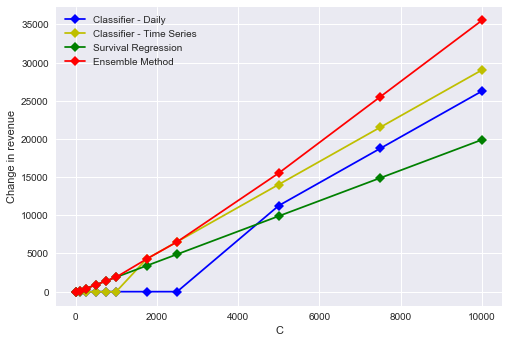

In [6]:
plt.plot(Cs, np.array(revenue_pred) - np.array(revenue_prev), 'b', marker = 'D', label = 'Classifier - Daily')
plt.plot(Cs, np.array(revenue_ts) - np.array(revenue_prev), 'y', marker = 'D', label = 'Classifier - Time Series')
plt.plot(Cs, np.array(revenue_s) - np.array(revenue_prev), 'g', marker = 'D', label = 'Survival Regression')
plt.plot(Cs, np.array(revenue_en) - np.array(revenue_prev), 'r', marker = 'D', label = 'Ensemble Method')
plt.xlabel('C')
plt.ylabel('Change in revenue')
plt.legend()
plt.show()

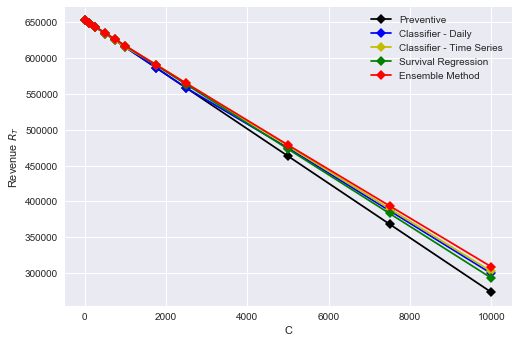

In [7]:
plt.plot(Cs, np.array(revenue_prev), 'k', marker = 'D', label = 'Preventive')
plt.plot(Cs, np.array(revenue_pred), 'b', marker = 'D', label = 'Classifier - Daily')
plt.plot(Cs, np.array(revenue_ts), 'y', marker = 'D', label = 'Classifier - Time Series')
plt.plot(Cs, np.array(revenue_s), 'g', marker = 'D', label = 'Survival Regression')
plt.plot(Cs, np.array(revenue_en), 'r', marker = 'D', label = 'Ensemble Method')
plt.xlabel('C')
plt.ylabel('Revenue $R_T$')
plt.legend()
plt.show()

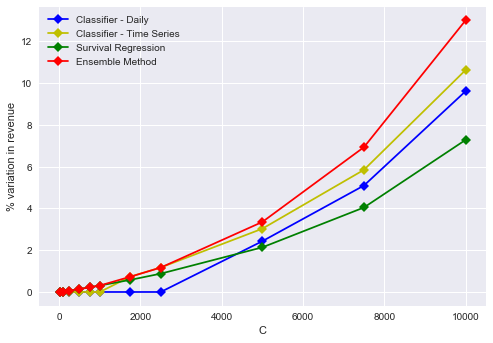

In [8]:
perc_d = ((np.array(revenue_pred) - np.array(revenue_prev))/np.array(revenue_prev))*100
perc_ts = ((np.array(revenue_ts) - np.array(revenue_prev))/np.array(revenue_prev))*100
perc_s = ((np.array(revenue_s) - np.array(revenue_prev))/np.array(revenue_prev))*100
perc_en = ((np.array(revenue_en) - np.array(revenue_prev))/np.array(revenue_prev))*100

plt.plot(Cs, perc_d, 'b', marker = 'D', label = 'Classifier - Daily')
plt.plot(Cs, perc_ts, 'y', marker = 'D', label = 'Classifier - Time Series')
plt.plot(Cs, perc_s, 'g', marker = 'D', label = 'Survival Regression')
plt.plot(Cs, perc_en, 'r', marker = 'D', label = 'Ensemble Method')
plt.xlabel('C')
plt.ylabel('% variation in revenue')
plt.legend()
plt.show()